In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt

### Graph of communications modelling

In [31]:
# Read the citation_relations.json file and generate a graph
with open('./data/citation_relations.json', 'r') as f:
    cite_data = json.load(f)

In [32]:
# Check if there are duplicate entries in the graph
node_set = set()
for paper_id in cite_data.keys():
    node_set.add(paper_id)
print(f"Duplicates count = {len(cite_data.keys()) - len(node_set)}")

Duplicates count = 0


In [33]:
# Create a list of nodes in the format expected by networkX
node_list = []
index_dict = {} # Keep a dictionary to map paper_code to index
for index, paper_code in enumerate(cite_data.keys()):
    node_list.append({ 'id': index })
    index_dict[paper_code] = index

In [34]:
# Create a list of links in the format expected by networkX
link_list = []
for paper_id, paper_data in cite_data.items():
    for ref_paper_id in paper_data['references']:
        link_list.append({ 'source': index_dict[paper_id], 'target': index_dict[ref_paper_id] })

In [35]:
# Create an undirected graph from the node and link lists
graph_data = {
    'directed': False,
    'multigraph': False,
    'graph': {},
    'nodes': node_list,
    'links': link_list
}
G_comm = nx.node_link_graph(graph_data)

In [36]:
print(f"Number of nodes = {G_comm.number_of_nodes()}, number of edges = {G_comm.number_of_edges()}")

Number of nodes = 140799, number of edges = 658226


In [37]:
# Sample the graph to reduce its size 
from littleballoffur import RandomNodeSampler

total_nodes = G_comm.number_of_nodes()
sample_size = total_nodes // 10
sampler = RandomNodeSampler(number_of_nodes=sample_size, seed=42)
sampled_graph = sampler.sample(G_comm)

# Keep the largest connected component
largest_cc = max(nx.connected_components(sampled_graph), key=len)
sampled_graph = sampled_graph.subgraph(largest_cc).copy()

print(f"Sampled graph is connected = {nx.is_connected(sampled_graph)}")
print(f"Sampled graph is directed = {nx.is_directed(sampled_graph)}")
print(f"Number of nodes = {sampled_graph.number_of_nodes()}, number of edges = {sampled_graph.number_of_edges()}")

Sampled graph is connected = False
Sampled graph is directed = False
Number of nodes = 14079, number of edges = 6267


In [40]:
# Create a list of sampled nodes in the format expected by networkX
sampled_nodes = list(sampled_graph.nodes)
sampled_node_list = []
for node in sampled_nodes:
    sampled_node_list.append({ 'id': node, 'name': str(node) })

In [41]:
# Create a list of sampled links in the format expected by networkX
sampled_link_list = []
for paper_id, paper_data in cite_data.items():
    if index_dict[paper_id] not in sampled_graph.nodes:
        continue
    for ref_paper_id in paper_data['references']:
        if index_dict[ref_paper_id] in sampled_graph.nodes:
            sampled_link_list.append({ 'source': index_dict[paper_id], 'target': index_dict[ref_paper_id] })

In [42]:
# Create a graph from the sampled node and link lists
sampled_graph_data = {
    'directed': True,
    'multigraph': False,
    'graph': {},
    'nodes': sampled_node_list,
    'links': sampled_link_list
}
G_comm = nx.node_link_graph(sampled_graph_data)

### Create the network of similarities of communications

In [43]:
# Load the papers data
with open('./data/papers.SSN.jsonl', 'r') as f:
    papers = f.readlines()

In [44]:
papers[0]

'{"paper_id": "4650265", "title": "XGBoost: A Scalable Tree Boosting System", "abstract": ["tree boosting is a highly effective and widely used machine learning method .", "in this paper , we describe a scalable end - to - end tree boosting system called xgboost , which is used widely by data scientists to achieve state - of - the - art results on many machine learning challenges .", "we propose a novel sparsity - aware algorithm for sparse data and weighted quantile sketch for approximate tree learning .", "more importantly , we provide insights on cache access patterns , data compression and sharding to build a scalable tree boosting system .", "by combining these insights , xgboost scales beyond billions of examples using far fewer resources than existing systems ."], "section_names": ["introduction", "tree boosting in a nutshell", "regularized learning objective", "gradient tree boosting", "shrinkage and column subsampling", "basic exact greedy algorithm", "approximate algorithm", 

In [45]:
# Keep the abstracts of the papers that are in the sampled graph
abstracts = []
for paper in papers:
    paper_data = json.loads(paper)
    if index_dict[paper_data['paper_id']] not in sampled_nodes:
        continue
    abstracts.append((paper_data['paper_id'], " ".join(paper_data['abstract'])))

In [46]:
print(abstracts[0][0], index_dict[abstracts[0][0]], index_dict[abstracts[0][0]] in sampled_nodes)

202120843 4104 True


In [47]:
print(f"Number of abstracts = {len(abstracts)}")

Number of abstracts = 1291


In [49]:
# Calculate the similarity between the abstracts using n-grams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 3))
X = vectorizer.fit_transform([abstract for _, abstract in abstracts])
similarity_matrix = cosine_similarity(X, X)

In [50]:
# Create a graph from the similarity matrix
# Draw an edge between papers with similarity in the fourth quartile

# Calculate the 75th percentile of the similarity matrix
import numpy as np
percentile_75 = np.percentile(similarity_matrix, 75)
print(f"75th percentile = {percentile_75:.3f}")

G_sim = nx.Graph()
for i in range(similarity_matrix.shape[0]):
    for j in range(i+1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] > percentile_75:
            source_node = index_dict[abstracts[i][0]]
            target_node = index_dict[abstracts[j][0]]
            G_sim.add_edge(source_node, target_node)

75th percentile = 0.047


In [32]:
# Save the graph to a CSV file
nx.write_edgelist(G_sim, './data/similarity_graph.csv', delimiter=',')

### Load the network of similarities of communications

In [12]:
G_sim = nx.read_edgelist('./data/similarity_graph.csv', delimiter=',')

### Calculate the intersection between netoworks of commucication and networks of simialrity of communication

In [51]:
# Vefify that communication and similarity graphs have the same nodes
comm_nodes = set(G_comm.nodes)
sim_nodes = set(G_sim.nodes)
print(f"Difference in nodes = {comm_nodes - sim_nodes}")
print(f"Percentage of nodes in common = {len(comm_nodes.intersection(sim_nodes)) / len(comm_nodes)}")

Difference in nodes = set()
Percentage of nodes in common = 1.0


In [52]:
# Iterate over all nodes and find the neighbors of each node in G_comm and G_sim
intersection_dict = {}
for node in G_comm.nodes:
    network_comm_neighbors = set(G_comm.neighbors(node))
    network_sim_neighbors = set(G_sim.neighbors(node))
    intersection = network_comm_neighbors.intersection(network_sim_neighbors)
    union = network_comm_neighbors.union(network_sim_neighbors)
    jaccard_similarity = len(intersection) / len(union)
    intersection_dict[node] = {
        'intersection': list(intersection),
        'union': list(union),
        'jaccard_similarity': jaccard_similarity
    }

In [ ]:
# Save the intersection dictionary to a JSON file
with open('./data/intersection_dict.json', 'w') as f:
    json.dump(intersection_dict, f, indent=4)

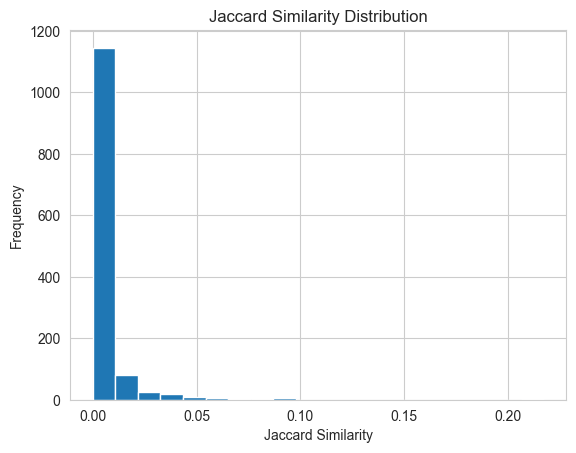

In [53]:
# Plot the distribution of Jaccard similarities
jaccard_values = [value['jaccard_similarity'] for value in intersection_dict.values()]
plt.hist(jaccard_values, bins=20)
plt.xlabel('Jaccard Similarity')
plt.ylabel('Frequency')
plt.title('Jaccard Similarity Distribution')
# plt.savefig('./data/jaccard_similarity_distribution_ngrams.png')
plt.show()

### Permutation test

In [74]:
import random

# Define population for permutation test
comm_population = []
for node in G_comm.nodes:
    comm_neighbors = set(G_comm.neighbors(node))
    comm_population.append(list(comm_neighbors))

sim_population = []
for node in G_sim.nodes:
    sim_neighbors = set(G_sim.neighbors(node))
    sim_population.append(list(sim_neighbors))
    
G_comm_nodes = list(G_comm.nodes)

# Perform the permutation test by examining random pairs of communication and similarity networks
num_permutations = 100
p_values = []
permuted_jaccard_values = []
observed_jaccard_values = []

for i in range(num_permutations):
    # Choose a network of communication
    comm_network = set(comm_population[i])
    # Retrieve the Jaccard similarity calculated before for the specific network
    observed_jaccard_values.append(intersection_dict[G_comm_nodes[i]]['jaccard_similarity'])
    # Try different combinations with networks of similarity
    for _ in range(num_permutations):
        # Permute the networks of similarity
        random.shuffle(sim_population)
        # Take into account only the first 100 networks due to computational constraints
        for j in range(0, 100):
            sim_network = set(sim_population[j])
            # Calculate the Jaccard similarity for the specific pair of networks
            intersection = comm_network.intersection(sim_network)
            union = comm_network.union(sim_network)
            jaccard_similarity = len(intersection) / len(union) if len(union) > 0 else 0
            permuted_jaccard_values.append(jaccard_similarity)
            # Check if the Jaccard similarity is greater than the observed one
            p_values.append(jaccard_similarity >= observed_jaccard_values[-1])

# Calculate the p-value and the observed Jaccard similarity
p_value = np.mean(p_values)
observed_jaccard = np.mean(observed_jaccard_values)
print(f"Observed Jaccard similarity = {observed_jaccard:.5f}")
print(f"p-value = {p_value}")

Observed Jaccard similarity = 0.00508
p-value = 0.337074


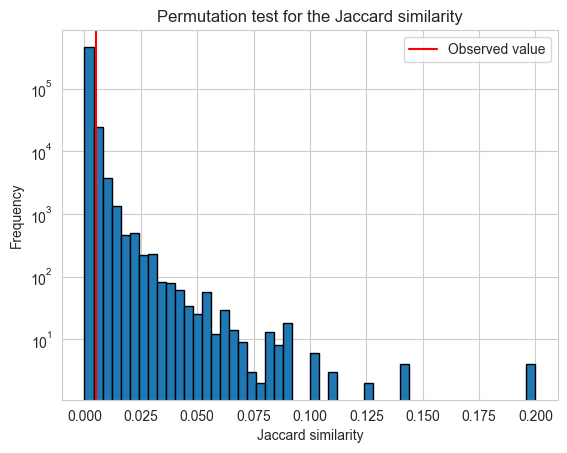

In [79]:
# Visualise the permutation test
fig, ax = plt.subplots()
ax.hist(permuted_jaccard_values, bins=50, edgecolor='black')
ax.axvline(x=observed_jaccard, color='red', label='Observed value')
ax.semilogy()
ax.set_xlabel('Jaccard similarity')
ax.set_ylabel('Frequency')
ax.set_title('Permutation test for the Jaccard similarity')
ax.legend()
# fig.savefig('./data/permutation_test_jaccard_similarity.png')
plt.show()

In [23]:
del papers